In [1]:
#Loads modules
import torch as t
import matplotlib.pyplot as plt

import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import json

import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls
import Evolvers as Evolvers

In [64]:
experiment = "Flensmon2D_5"

In [102]:
#Loads the params_dict for the experiment
exp_path = os.path.join(dir_path,"Experiments",experiment)

params_filepath = os.path.join(exp_path,"Parameters.json")
with open(params_filepath) as json_file:
    params_dict = json.load(json_file)

params_dict.update({"exp_path":exp_path})

I added a factor half to the cosines
Loaded UE0s


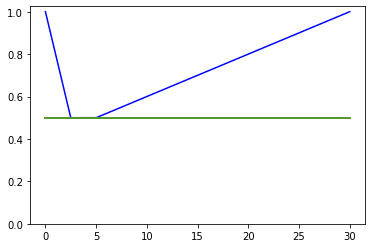

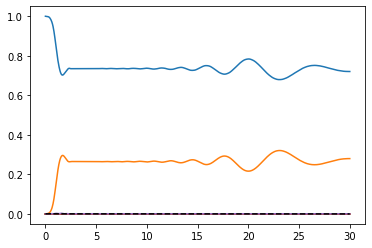

In [105]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)
importlib.reload(Evolvers)

class Flensmon(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.ETrotter, Training.Trainer, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        super(t.nn.Module,self).__init__()
        return
    
    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        # self.latest_matrix_exp = self.basis_change@t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))

    def V_1d(self, alphas, control):
        return self.EJ*(-2*self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            + alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)

obj = Flensmon(params_dict)
# obj.plot_potential()
obj.plot_activation_func()
obj.plot_occupancy(indices=[_ for _ in range(5)])

In [150]:
obj.dt

0.030030028894543648

In [1650]:
# obj.test = lambda: print("lol")
# obj.get_control = lambda: t.load(os.path.join(obj.params_dict['exp_path'],"21_09_1607_pulse.pt"))
# obj.get_occupancy()
# obj()

In [134]:
obj.minimize(0.01,2000)

initial loss: 0.7272723317146301
Ended at step: 3718, with loss: 0.8428425788879395 and runtime: 4113.169202566147


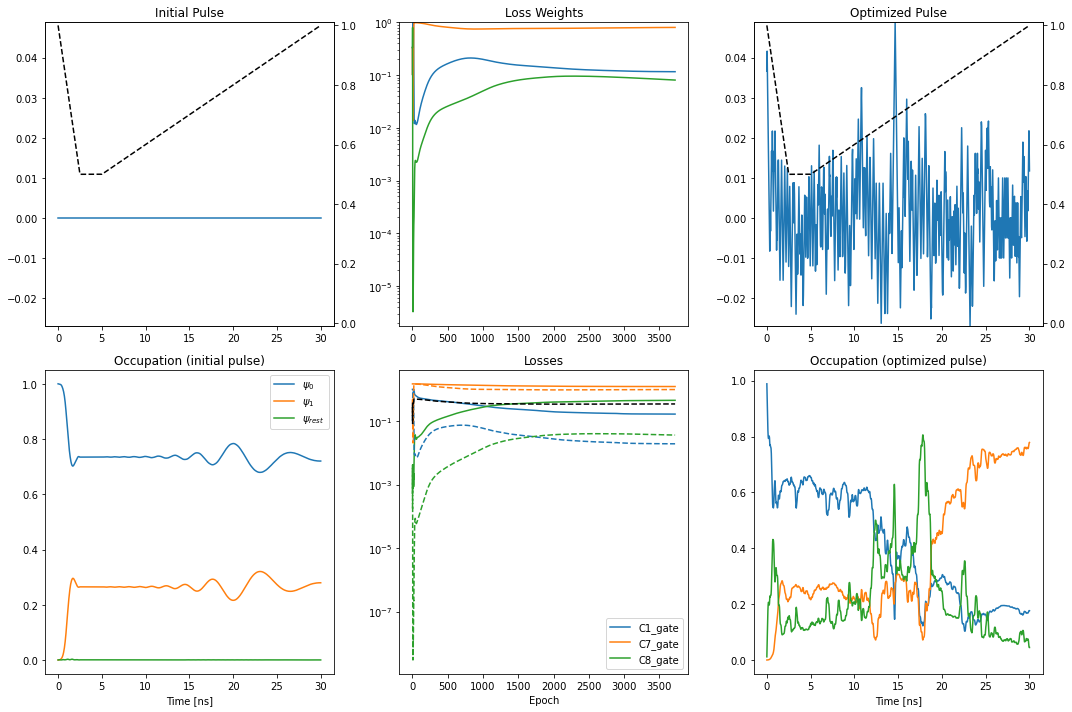

In [152]:
obj.plot_run(save=False,fig_name="ConstrainedPulse_XGate_0toPulse_withC7C8.pdf")

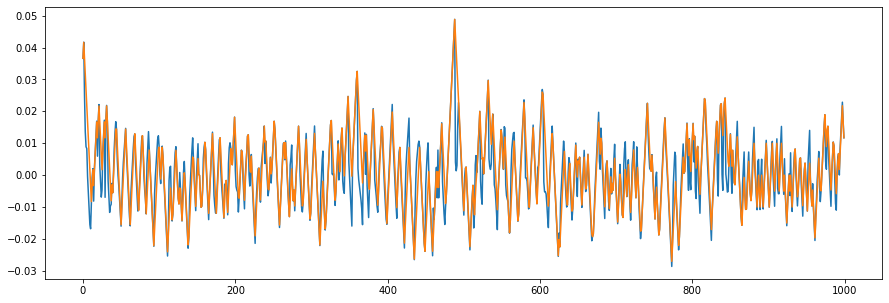

In [153]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(obj.heights.detach())
ax.plot(obj.get_control().detach())
# ax.set_xlim(0,100)

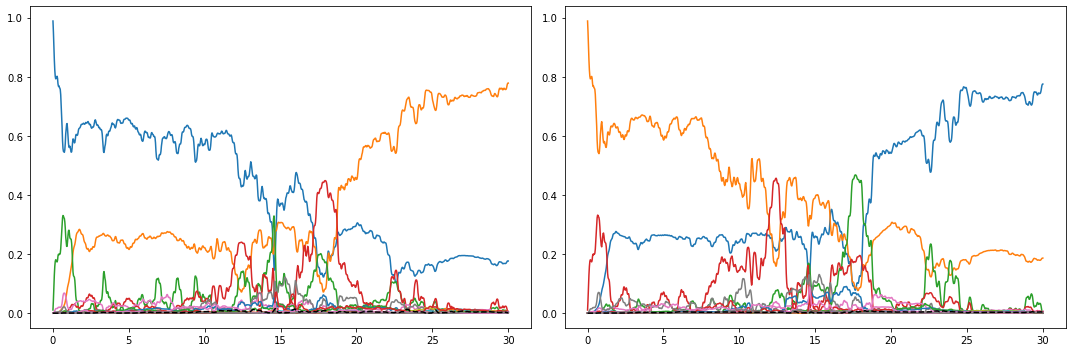

In [154]:
fig, ax = plt.subplots(figsize=(15,5),ncols=2)
# for i in range(2):
occ = obj.get_occupancy([_ for _ in range(18)],[0,1]).detach()

ax[0].plot(obj.times,occ[:-1,:,0].T)
ax[0].plot(obj.times,occ[-1,:,0],'k--')

ax[1].plot(obj.times,occ[:-1,:,1].T)
ax[1].plot(obj.times,occ[-1,:,1],'k--')
fig.tight_layout()

In [139]:
U = obj()

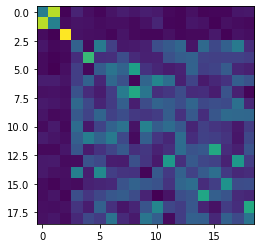

In [140]:
plt.imshow(U.abs().detach())

In [156]:
# t.save(pulse,os.path.join(obj.params_dict['exp_path'],"22_09_1435_pulse.pt"))

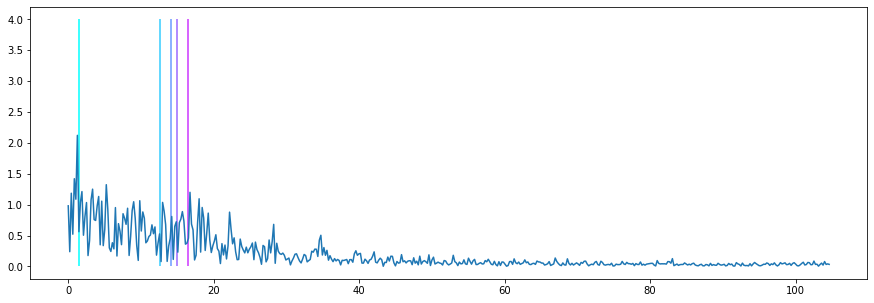

In [155]:
pulse = obj.get_control().detach().clone()
eigvals = obj.H0_term[500].real.diagonal()
energies = [eigvals[3]-eigvals[2],
            eigvals[2]-eigvals[1],
            eigvals[3]-eigvals[1],
            eigvals[2]-eigvals[0],
            eigvals[3]-eigvals[0]]


fft = t.fft.rfft(pulse)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(t.linspace(0,t.pi/obj.dt,obj.NTrot//2+1),fft.abs())
# ax.set_xlim(-1,20)
for i,E in enumerate(energies):
    ax.vlines(E,0,4,colors=(i/len(energies),1-i/len(energies),1))

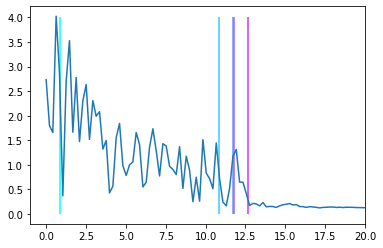

In [530]:
pulse = obj.get_control().detach().clone()
eigvals = obj.H0_term[0].real.diagonal()
energies = [eigvals[3]-eigvals[2],
            eigvals[2]-eigvals[1],
            eigvals[3]-eigvals[1],
            eigvals[2]-eigvals[0],
            eigvals[3]-eigvals[0]]


fft = t.fft.rfft(pulse)
fig, ax = plt.subplots()
ax.plot(t.linspace(0,t.pi/obj.dt,obj.NTrot//2+1),fft.abs())
ax.set_xlim(-1,20)
for i,E in enumerate(energies):
    ax.vlines(E,0,4,colors=(i/len(energies),1-i/len(energies),1))